# Brain tumor classification project

In [1]:
# Import libraries for data visualization and data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, decode_predictions, preprocess_input
from tensorflow.keras import Sequential,Input,Model
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

## Test 1

In [ ]:
# Load example image (no tumor)
img = image.load_img('data/normal/N_1.jpg',target_size=(224,224)) 

In [ ]:
# Load example image (tumor)
img = image.load_img('data/tumor/glioma_tumor/G_1.jpg',target_size=(224,224)) 

In [ ]:
# Plot image 
plt.imshow(img)

In [ ]:
# Convert image to array, can also specify datatype
img = image.img_to_array(img,dtype='uint8')
img.shape

In [ ]:
# Initialize the model
model = ResNet50()
#model = VGG16()
#model = VGG19()

In [ ]:
# Show model summary
model.summary()

In [ ]:
# Check shape required by model
model.input.shape

In [ ]:
# Reshape to match the input shape required by the model
img = np.expand_dims(img,axis=0)
img.shape 

### Prediction (without image preprocessing) 

In [ ]:
pred = model.predict(img)
pred.shape

In [ ]:
# Decode labels
decode_predictions(pred)

### Prediction (with image preprocessing) 

In [ ]:
# Preprocess image
img = preprocess_input(img) 

In [ ]:
plt.imshow(img[0])

In [ ]:
pred = model.predict(img)
pred.shape

In [ ]:
# Decode labels
decode_predictions(pred)

## Test 2 - Use pretrained model

In [4]:
classes = ['normal','tumor']
#classes = ['normal','glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

In [2]:
# Define the preprocessing pipeline used when generating images
data_gen = image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
# Define the preprocessing pipeline used when generating images
data_gen = image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=(0.5,1.5),
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
)

In [5]:
# Image generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory='dataset_auto/train',
        class_mode="categorical",
        classes=classes,
        batch_size=5,
        target_size=(224, 224),
)

Found 210 images belonging to 2 classes.


In [6]:
val_data_gen = data_gen.flow_from_directory(
        directory='dataset_auto/validation/',
        class_mode="categorical",
        classes=classes,
        batch_size=5,
        target_size=(224, 224),
)

Found 210 images belonging to 2 classes.


In [7]:
train_data_gen.class_indices

{'normal': 0, 'tumor': 1}

In [8]:
import tensorflow.keras.backend as K
K.clear_session()

# 1. Select the convolutional base / Pretrained network
base_model = ResNet50(include_top=False)
#base_model = VGG16(include_top=False)
#base_model = VGG19(include_top=False)

In [9]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [10]:
# 2. Freeze the weights in order to not retrain the loaded pre-trained model
base_model.trainable= False

In [11]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [12]:
# 3. Create your model with pretrained network as base model
inputs = Input(shape=(224,224,3))

base = base_model(inputs)

# can also add additional cnn layers if necessary

# dont forget to flatten out before the final layer
flatten = GlobalAveragePooling2D()(base)

outputs = Dense(2,activation='softmax')(flatten)

model_tf = Model(inputs,outputs)

In [13]:
model_tf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [14]:
model_tf.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_tf.fit(train_data_gen,
          verbose=2, # how the training log should get printed 
          epochs=10,
          validation_data=val_data_gen)

Epoch 1/10
42/42 - 16s - loss: 0.5439 - accuracy: 0.7190 - val_loss: 0.4856 - val_accuracy: 0.7905 - 16s/epoch - 379ms/step
Epoch 2/10
42/42 - 15s - loss: 0.1256 - accuracy: 0.9762 - val_loss: 0.4655 - val_accuracy: 0.7810 - 15s/epoch - 355ms/step
Epoch 3/10
42/42 - 16s - loss: 0.0639 - accuracy: 0.9952 - val_loss: 0.4600 - val_accuracy: 0.7905 - 16s/epoch - 369ms/step
Epoch 4/10
42/42 - 16s - loss: 0.0429 - accuracy: 0.9952 - val_loss: 0.4488 - val_accuracy: 0.7762 - 16s/epoch - 381ms/step
Epoch 5/10
42/42 - 17s - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.4697 - val_accuracy: 0.7905 - 17s/epoch - 396ms/step
Epoch 6/10
42/42 - 18s - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.4448 - val_accuracy: 0.7857 - 18s/epoch - 420ms/step
Epoch 7/10
42/42 - 22s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.4893 - val_accuracy: 0.7810 - 22s/epoch - 519ms/step
Epoch 8/10
42/42 - 41s - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.4880 - val_accuracy: 0.7857 - 41s/epoch - 987ms/step
Epoch 9/

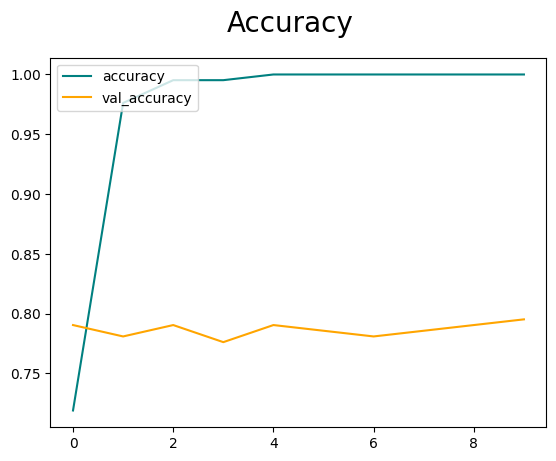

In [15]:
# Plot: Accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

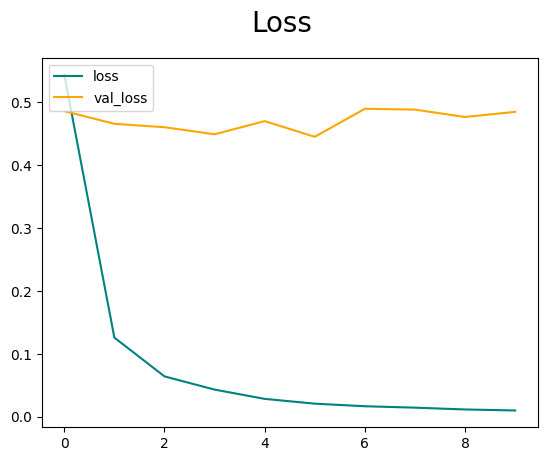

In [16]:
# Plot: Loss
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Predict one example image:

In [ ]:
model_tf.predict(img)

In [ ]:
plt.bar(x = classes, height = model_tf.predict(img)[0])

In [ ]:
# For remapping the index values of highest prediction probability to its respective class
pred = model_tf.predict(img)

preds_cls = list(train_data_gen.class_indices.keys())[list(train_data_gen.class_indices.values()).index(np.argmax(pred,axis=-1))]
preds_cls

In [ ]:
#model.save('models/tumor_ResNet50.h5')
#model.save('models/tumor_VGG16.h5')
#model.save('models/tumor_VGG19.h5')

Predict multiple example images:

In [ ]:
# load all images into a list
import os

folder_path = "dataset/train/normal" # Change according to you folder path
images = []
#for img in os.listdir(folder_path):
for img in sorted(os.listdir(folder_path)):
    #print(img)
    img = os.path.join(folder_path, img)
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img,dtype='uint8')
    img = np.expand_dims(img, axis=0)
    images.append(img)  

In [ ]:
# stack up images list to pass for prediction
images = np.vstack(images)
classes = model_tf.predict(images,batch_size=15)
print(classes)

In [ ]:
classes_2 = model_tf.predict(images,batch_size=15)
classes_2_type = classes_2.argmax(axis=-1)

In [ ]:
classes_2_type

In [ ]:
sns.barplot(y=classes_2_type)